In [1]:
%cd "/home/jorgen/deepshape/deepshape/"
%load_ext autoreload
%autoreload 2

/home/jorgen/deepshape/deepshape


In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import time

In [3]:
from layers import FourierLayer2D
from palais_layer import *
from surfaces import *
from visual import *
from networks import *
from curves import LogStepDiff

plt.rcParams["figure.figsize"] = (8.3, 5.6)
plt.rcParams["font.size"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16

In [4]:
savepath = "/home/jorgen/masters-thesis-shape-analysis/chapter05/figures/deep/rotation/"
# TODO: Create example surfaces library, and load from there.
C = (
    lambda x: x[..., 0],
    lambda x: x[..., 1],
    lambda x: x[..., 0]**2 - x[..., 1]**2
)



f = Surface(C)

def angle(x):
    return 0.5 * np.pi * torch.sin(np.pi * x[..., 0]) * torch.sin(np.pi * x[..., 1])

γ = Diffeomorphism(
    (
        lambda x: (x[..., 0] - 0.5) * torch.cos(angle(x)) - (x[..., 1] - 0.5) * torch.sin(angle(x)) + 0.5,
        lambda x: (x[..., 0] - 0.5) * torch.sin(angle(x)) + (x[..., 1] - 0.5) * torch.cos(angle(x)) + 0.5
))

g = f.compose(γ)
q = Qmap(g)
r = Qmap(f)

# Get color normalizer
k = 256
fcolors = get_plot_data(f.volume_factor, k=k).squeeze()
gcolors = get_plot_data(g.volume_factor, k=k).squeeze()
norm = colors.Normalize(vmin=min(fcolors.min(), gcolors.min()), vmax=max(fcolors.max(), gcolors.max()))

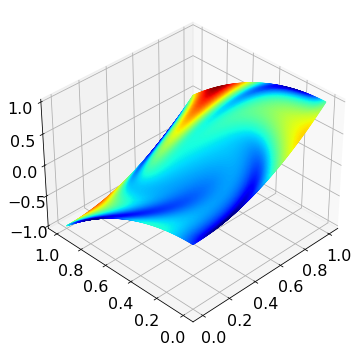

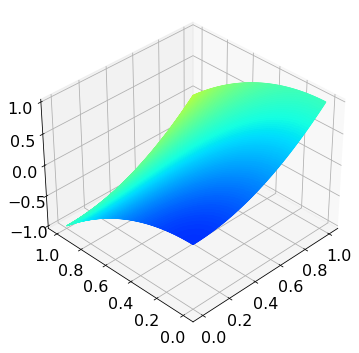

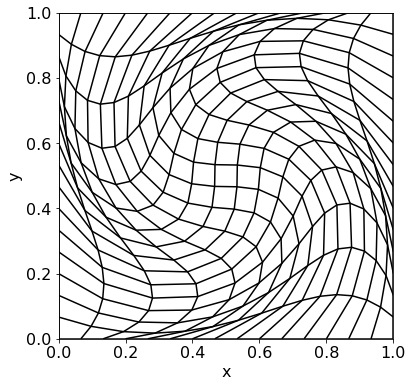

In [5]:
k = 256
Z = get_plot_data(g, k=k)
gcolors = get_plot_data(g.volume_factor, k=k).squeeze()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(*Z, shade=False, facecolors=cm.jet(norm(gcolors)), rstride=1, cstride=1)
ax.view_init(35, 225)
plt.savefig(savepath + "warped-surface.png", bbox_inches="tight")
plt.show()

Z = get_plot_data(f, k=k)
fcolors = get_plot_data(f.volume_factor, k=k).squeeze()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(*Z, shade=False, facecolors=cm.jet(norm(fcolors)), rstride=1, cstride=1)
ax.view_init(35, 225)
plt.savefig(savepath + "regular-surface.png", bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(6, 6))
plot_diffeomorphism(γ, k=16, color="k")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(savepath + "base-diffeomorphism.png", bbox_inches="tight")
plt.show()

In [6]:
bfgs_iter = 300
iterations = 1

# Instantiate a L-layer network with N basis functions per layer.
RN = ReparametrizationNetwork2D(3, 15, layer_type=PalaisLayer2D)
optimizer = optim.LBFGS(RN.parameters(), lr=0.9, max_iter=bfgs_iter, max_eval=bfgs_iter, line_search_fn="strong_wolfe")
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, threshold=0.,
                                                 threshold_mode='rel', cooldown=10, min_lr=1e-3, eps=1e-08, verbose=True)
loss = nn.MSELoss()

printiter= 20
errors = np.empty(bfgs_iter * iterations)
errors[:] = np.nan

# Create Datapoints
k = 32
K = k**2
X, Y = torch.meshgrid((torch.linspace(0, 1, k), torch.linspace(0, 1, k)))
X, Y = X.reshape(-1, 1), Y.reshape(-1, 1)
X = torch.cat((X, Y), dim=1)

tic = time.time()
for i in range(iterations):
    print("Iteration i")
    inner = [0]
    
    def closure():
        # Set gradient buffers to` zero.
        optimizer.zero_grad()
        
        with torch.no_grad():
            Z = X
            for layer in RN.layers:
                layer.project(Z, 1e-3, 1e-3)
                Z, _ = layer(Z)

        Q = q(X)
        R = RN.reparametrized(r, X)

        # Compute loss, and perform a backward pass and gradient step
        l = loss(Q, R) * 3
        l.backward()
        scheduler.step(l)
        
        j = i * bfgs_iter + inner[0]
        errors[j] = l.item()
        inner[0] += 1

        
        print('[Iter %5d] loss: %.8f' % (j, l))
        return l
    
    optimizer.step(closure)
#     scheduler.step(closure())

                
    # Should insert projection step here as well (has not been necessary until now) 
toc = time.time()

print()
print(f'Finished training in {toc - tic:.5f}s')

Iteration i
[Iter     0] loss: 0.25796583
[Iter     1] loss: 0.09250034
[Iter     2] loss: 0.03766949
[Iter     3] loss: 0.02524979
[Iter     4] loss: 0.01804992
[Iter     5] loss: 0.00722011
[Iter     6] loss: 0.00470271
[Iter     7] loss: 0.00292383
[Iter     8] loss: 0.00224140
[Iter     9] loss: 0.00176399
[Iter    10] loss: 0.00124775
[Iter    11] loss: 0.00099362
[Iter    12] loss: 0.00086424
[Iter    13] loss: 0.00076402
[Iter    14] loss: 0.00067046
[Iter    15] loss: 0.00054394
[Iter    16] loss: 0.00047929
[Iter    17] loss: 0.00043770
[Iter    18] loss: 0.00040524
[Iter    19] loss: 0.00037418
[Iter    20] loss: 0.00032820
[Iter    21] loss: 0.00029882
[Iter    22] loss: 0.00028312
[Iter    23] loss: 0.00026475
[Iter    24] loss: 0.00024776
[Iter    25] loss: 0.00022907
[Iter    26] loss: 0.00021556
[Iter    27] loss: 0.00020433
[Iter    28] loss: 0.00019657
[Iter    29] loss: 0.00018852
[Iter    30] loss: 0.00017683
[Iter    31] loss: 0.00016649
[Iter    32] loss: 0.0001590

[Iter   273] loss: 0.00000094
[Iter   274] loss: 0.00000093
[Iter   275] loss: 0.00000092
[Iter   276] loss: 0.00000091
[Iter   277] loss: 0.00000090
[Iter   278] loss: 0.00000089
[Iter   279] loss: 0.00000088
[Iter   280] loss: 0.00000087
[Iter   281] loss: 0.00000086
[Iter   282] loss: 0.00000085
[Iter   283] loss: 0.00000084
[Iter   284] loss: 0.00000084
[Iter   285] loss: 0.00000083
[Iter   286] loss: 0.00000082
[Iter   287] loss: 0.00000082
[Iter   288] loss: 0.00000081
[Iter   289] loss: 0.00000080
[Iter   290] loss: 0.00000079
[Iter   291] loss: 0.00000078
[Iter   292] loss: 0.00000077
[Iter   293] loss: 0.00000077
[Iter   294] loss: 0.00000076
[Iter   295] loss: 0.00000075
[Iter   296] loss: 0.00000074
[Iter   297] loss: 0.00000073
[Iter   298] loss: 0.00000073
[Iter   299] loss: 0.00000072

Finished training in 65.54845s


In [ ]:
k = 240
fafter = f.compose(lambda x: RN(x)[0])
Z = get_plot_data(fafter, k=k)
fafcolors = get_plot_data(fafter.volume_factor, k=k).squeeze()

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(*Z, shade=False, facecolors=cm.jet(norm(fafcolors)), rstride=1, cstride=1)
ax.view_init(35, 225)
plt.savefig(savepath + "regular-warped-matched-surface.png", bbox_inches="tight")
plt.show()

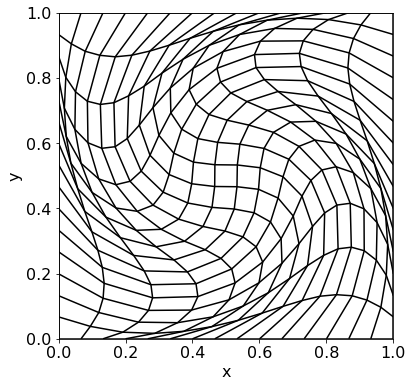

In [9]:
fig = plt.figure(figsize=(6, 6))
plot_diffeomorphism(lambda x: RN(x)[0], k=16, color="k")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(savepath + "regular-warped-diffeomorphism.png", bbox_inches="tight")
plt.show()

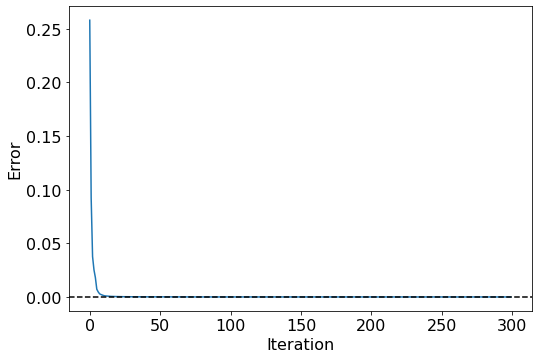

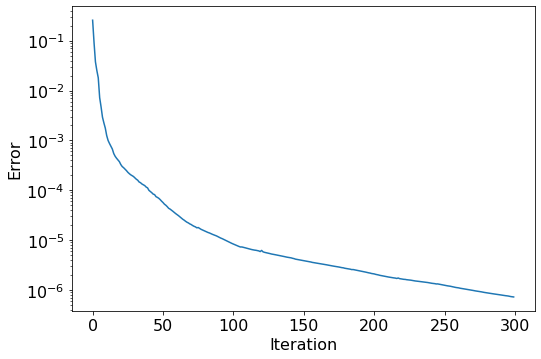

In [10]:
plt.figure()
plt.plot(errors)
plt.axhline(0., ls="--", c="black")

plt.ylabel("Error", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.savefig(savepath + "regular-warped-error-linear.png", bbox_inches="tight")

plt.figure()
plt.semilogy(errors)
plt.axhline(0., ls="--", c="black")
plt.ylabel("Error", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.savefig(savepath + "regular-warped-error-semilogy.png", bbox_inches="tight")

plt.show()

In [11]:
# Create Datapoints
k = 256
K = k**2
X = torch.rand(K, 2)
X, Y = torch.meshgrid((torch.linspace(0, 1, k), torch.linspace(0, 1, k)))
X, Y = X.reshape(-1, 1), Y.reshape(-1, 1)
X = torch.cat((X, Y), dim=1)

Z, Y = RN(X)
(γ(X) - Z).norm(np.inf)

tensor(0.0113, grad_fn=<NormBackward1>)